In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, cv
from scipy.stats import mannwhitneyu, chi2_contingency
pd.set_option('display.max_columns', None)

In [2]:
# monthly_income - среднемесячный заработок клиента (зарплата)
# payment_frequency - частота получения зарплаты (month - 1 раз в месяц, 2 weeks - раз в две недели, и тд)
# status - статус клиента (самозанятый, рабочий, и тд)
# work_experience - кол-во лет стажа клиента
# client_type - тип клиента (новый, повторный)
# settlement - город клиента
# requested_sum - запрашиваемая сумма клиента для займа, если interface - alfa
# region - регион клиента (область, округ, и тд)
# loan_id - уникальный идентификатор займа
# client_id - уникальный идентификатор клиента
# main_agreement_amount - основная одобренная сумма клиенту по займу (может быть больше, чем approved_amount)
# main_agreement_term - основной одобренный срок по займу
# requested_period_days - запрашиваемый срок по займу
# requested_amount - запрашиваемая сумма клиента по займу
# req_app_amount - разница между запрашиваемой суммой займа и одобренной
# approved_amount - одобренная сумма по займу
# source - канал привлечения клиента
# first_source - первый канал привлечения клиента
# period_days - период страховки по займу
# interface - интерфейс, откуда пришла заявка - (site, mobile)
# created_at - дата открытия займа
# type - тип займа (тип продукта)
# closed_at - дата закрытия займа
# days_finish_loan - время в днях, затраченное на закрытие займа (closed_at - created_at)
# gender - пол клиента
# ag - возраст клиента
# repayment_type - Тип комиссии по займу (с 2.5% - with_comission, 5% - with_big_comission, 0% - no_comission)
# loan_order - порядковый номер займа
# have_extension - имеется ли пролонгация по данному займу
# cnt_ext - кол-во пролонгаций по займу
# start_dt - дата начала (список) пролонгаций по займу
# term - срок пролонгации (список)
# price - цена пролонгации (список)
# elecs_sum - штрафы, пени
# recurents_sum - штрафы, пени (там вроде как различия в этапах их начисления)
# tamount - общий кэшфлоу клиента (общая сумма которая была на аккаунте клиента)
# issues - сумма просрочек, штрафов и пени
# principal - сумма основного долга
# interest - прибыль с клиента
# overdue_interest - прибыль с клиента, если есть прослойка
# overdue_fee - штрафы в просрочек
# contact_cases - кол-во обращений клиента с коллекшн
# nbki_score - скор клиента от рисков

# churn - колонка таргета

In [2]:
# Загрузка датасета
csv_train = pd.read_csv('data/train.csv')
csv_test = pd.read_csv('data/test.csv')
csv_train.drop("closed_at", axis=1, inplace=True)
csv_train.drop("client_type.1", axis=1, inplace=True)

In [3]:
# Пример данных
csv_train.dropna().head(10)

,monthly_income,work_experience,requested_sum,main_agreement_amount,main_agreement_term,requested_period_days,requested_amount,req_app_amount,approved_amount,period_days,days_finish_loan,ag,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,issues,principal,interest,overdue_interest,overdue_fee,nbki_score,payment_frequency,status,loan_id,client_id,source,first_source,interface,type,repayment_type,client_type,settlement,region,gender,loan_order,have_extension,contact_cases,created_at,start_dt,churn
893291,-0.000745,0.952894,-0.137593,-0.985854,-0.340659,-0.389028,-0.083423,0.676039,-1.15210,-0.340659,0.235492,1.146578,-0.720608,-0.791301,-0.819496,-0.063933,-0.143015,-0.722724,0.852735,-0.852735,-0.240137,-0.218265,-0.185707,-1.718310,2,6,1041273,476925,0,0,2,2,3,1,г Калининград,обл Калининградская,male,3,1,1.0,2023-04-19 15:02:45,2023-05-19 20:06:26,0
1641711,-0.000752,0.084114,-0.429721,0.806835,-0.340659,-0.389028,-0.083423,-0.368229,0.45134,-0.340659,-0.078242,0.731075,-0.720608,-0.791301,-0.481401,-0.063933,-0.143015,0.543383,-0.662360,0.662360,0.355410,-0.218265,-0.185707,0.571364,2,1,1734418,598412,11,0,2,2,2,1,г Москва,г Москва,female,3,1,1.0,2023-07-28 15:46:51,2023-08-29 14:53:40,1
2144445,-0.000746,-0.784665,1.355506,-0.836463,0.176974,-0.389028,-0.524381,0.153905,-1.01848,0.176974,0.715321,-0.411560,-0.720608,-0.561187,-0.720355,-0.063933,-0.143015,-0.528798,0.726477,-0.726477,0.000084,-0.063315,-0.158757,-1.722646,2,0,345352,26550,11,0,2,2,3,1,село Черемошное,обл Белгородская,female,6,1,1.0,2022-11-18 11:45:21,2022-12-16 16:28:41,0
2245828,-0.000751,-2.522225,-0.494638,-0.836463,-0.340659,-0.389028,-1.053530,-0.368229,-1.01848,-0.340659,1.435063,-0.515436,-0.011155,-0.254370,-0.654039,-0.063933,1.482154,-0.242272,0.726477,-0.726477,0.204666,0.862401,-0.185707,-0.204870,2,1,4979407,1188242,0,0,2,2,0,0,село Горновое,край Алтайский,male,1,1,1.0,2024-08-20 08:55:47,2024-09-10 12:12:49,1
2610677,-0.000720,0.084114,-0.234969,0.209272,-0.340659,-0.389028,1.239449,1.285195,-0.08314,-0.340659,0.955235,-0.827063,-0.720608,-0.791301,-0.552579,-0.063933,3.778588,0.630587,-0.247603,0.247603,0.510478,1.846578,2.332450,-1.180584,2,1,3286055,79975,11,0,2,2,1,1,г Москва,г Москва,female,5,1,1.0,2024-01-31 17:21:59,2024-03-01 21:33:33,1
2725494,-0.000745,0.084114,-0.267427,0.209272,-0.340659,0.426103,-0.083423,-0.020140,-0.08314,-0.340659,0.789140,0.107820,-0.011155,-0.254370,-0.439245,-0.063933,-0.125350,0.555768,-0.157329,0.157329,1.298777,0.233674,-0.185707,0.063993,2,0,95164,43052,11,0,2,2,3,1,г Белгород,обл Белгородская,male,5,1,1.0,2022-08-14 22:43:49,2022-09-13 10:46:21,1
2988257,-0.000742,0.084114,-0.462179,0.358663,-0.340659,-0.389028,1.239449,1.198172,0.05048,-0.340659,1.804162,0.938827,2.117205,1.356423,1.048924,-0.063933,-0.143015,1.054600,-0.283587,0.283587,2.965308,-0.076227,-0.086782,-0.590819,2,1,61814,860,11,0,2,2,3,1,г Омск,обл Омская,male,4,1,1.0,2022-07-26 09:51:36,2022-08-22 16:52:18,0
2988874,-0.000739,-1.653445,-0.592014,0.321614,-0.340659,-0.389028,0.489821,0.545505,-0.08314,-0.340659,-0.041332,-0.723188,-0.720608,-0.791301,-0.544063,-0.063933,-0.143015,0.209215,-0.252275,0.252275,0.223499,-0.218265,-0.185707,-1.241295,2,8,91758,100397,0,0,2,2,3,0,село Аршаново,Респ Хакасия,female,1,1,1.0,2022-08-13 10:19:55,2022-09-04 14:25:00,0
3073339,-0.000746,-1.653445,-0.527097,0.358663,-0.340659,-0.389028,-0.965338,-0.977385,0.05048,-0.340659,2.523905,-1.450319,-0.720608,-0.791301,-0.585626,-0.063933,0.210282,1.354552,-0.283587,0.283587,0.735760,7.735855,10.659919,0.783852,2,1,2648826,537302,11,6,2,2,1,1,г Краснодар,край Краснодарский,male,9,1,3.0,2023-11-16 19:05:58,2023-12-16 16:32:13,0
3079826,-0.000750,-2.522225,-0.527097,-0.537681,-0.340659,-0.389028,-0.524381,-0.020140,-0.75124,-0.340659,4.277124,-1.242567,-0.011155,-0.254370,-0.578000,-0.063933,-0.143015,0.091358,0.473961,-0.473961,0.247812,2.913024,-0.185707,-1.462456,4,1,321814,156753,11,11,2,2,3,1,г Пермь,край Пермский,female,5,1,1.0,2022-11-10 19:53:12,2022-1

In [4]:
# Типы данных
csv_train.dtypes.sort_values()

churn                      int64
payment_frequency          int64
status                     int64
loan_id                    int64
client_id                  int64
source                     int64
interface                  int64
first_source               int64
repayment_type             int64
client_type                int64
loan_order                 int64
have_extension             int64
type                       int64
interest                 float64
contact_cases            float64
nbki_score               float64
overdue_fee              float64
principal                float64
monthly_income           float64
tamount                  float64
work_experience          float64
requested_sum            float64
main_agreement_amount    float64
main_agreement_term      float64
requested_period_days    float64
requested_amount         float64
issues                   float64
approved_amount          float64
req_app_amount           float64
days_finish_loan         float64
ag        

In [5]:
# col_categor - категориальные фичи, col_cont - количественные
col_categor = csv_train.dtypes[csv_train.dtypes == 'object'].index.tolist()
col_cont = csv_train.dtypes[csv_train.dtypes != 'object'].index.tolist()
col_cont.remove('churn')

In [6]:
# Сэмплы количественных фичей для выявление порядковых
for col in col_cont:
    print(csv_train[col][csv_train[col].notna()].head(5))

0   -0.000735
1   -0.000742
2   -0.000742
3   -0.000742
4   -0.000742
Name: monthly_income, dtype: float64
0    0.952894
1    0.952894
2    0.952894
3    0.952894
4    0.952894
Name: work_experience, dtype: float64
12    0.706333
14    2.653853
17    0.381746
25   -0.332345
26   -0.397262
Name: requested_sum, dtype: float64
0   -0.388291
1   -0.388291
2   -0.388291
3   -0.388291
4   -0.388291
Name: main_agreement_amount, dtype: float64
0   -0.340659
1   -1.145865
2   -0.685747
3    0.176974
4   -1.145865
Name: main_agreement_term, dtype: float64
0   -0.389028
1   -1.294731
2   -1.113590
3   -1.385301
4   -1.657011
Name: requested_period_days, dtype: float64
0   -1.053530
1   -0.436189
2   -0.259806
3    1.239449
4    0.357534
Name: requested_amount, dtype: float64
0   -0.629296
1   -0.020140
2    0.153905
3    1.633284
4    0.763061
Name: req_app_amount, dtype: float64
0   -0.61762
1   -0.61762
2   -0.61762
3   -0.61762
4   -0.61762
Name: approved_amount, dtype: float64
0   -0.340659
1

In [7]:
csv_train.created_at = pd.to_datetime(csv_train.created_at)
csv_train.start_dt = pd.to_datetime(csv_train.start_dt)

csv_test.created_at = pd.to_datetime(csv_test.created_at)
csv_test.start_dt = pd.to_datetime(csv_test.start_dt)

In [8]:
# col_ord - порядковые переменные, col_del - столбы с id не влияющими на таргет
col_ord = ["contact_cases", "payment_frequency", "repayment_type", "created_at", "start_dt"]
col_del = ["client_id", "loan_id", "loan_order"]
col_categor.remove("start_dt")
col_categor.remove("created_at")
col_categor.append("status")
col_categor.append("source")
col_categor.append("first_source")
col_categor.append("interface")
col_categor.append("type")
col_categor.append("client_type")
col_categor.append("have_extension")

for col in col_categor:
    if col in col_cont:
        col_cont.remove(col)
for col in col_ord:
    if col in col_cont:
        col_cont.remove(col)
for col in col_del:
    if col in col_cont:
        col_cont.remove(col)

In [9]:
# Приведение всех значений в диапозон от 0 до +ထ
s_1 = pd.concat([csv_test[col_cont].min(), csv_train[col_cont].min()], axis=1).min(axis=1)
csv_train[col_cont] = csv_train[col_cont] + s_1.abs() * 1.05
csv_test[col_cont] = csv_test[col_cont] + s_1.abs() * 1.05

# EDA

## КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ

In [10]:
# Сравнение значений признака между двумя группами относительно таргета 
for col in col_cont:
    stat, p_value = mannwhitneyu(csv_train[csv_train["churn"] == 0][col].dropna(), csv_train[csv_train["churn"] == 1][col].dropna())
    print(f"U-statistic: {round(stat, 3)}, p-value: {round(p_value, 3)}, {col}")

U-statistic: 1690350948468.0, p-value: 0.821, monthly_income
U-statistic: 200135504310.0, p-value: 0.433, work_experience
U-statistic: 24916607964.0, p-value: 0.347, requested_sum
U-statistic: 1690423014913.0, p-value: 0.894, main_agreement_amount
U-statistic: 1689348547838.5, p-value: 0.356, main_agreement_term
U-statistic: 1339288252873.5, p-value: 0.089, requested_period_days
U-statistic: 1361130619394.5, p-value: 0.737, requested_amount
U-statistic: 1361761632282.5, p-value: 0.303, req_app_amount
U-statistic: 1688994501253.0, p-value: 0.227, approved_amount
U-statistic: 1689348547838.5, p-value: 0.356, period_days
U-statistic: 1691267306326.0, p-value: 0.355, days_finish_loan
U-statistic: 1690886223778.5, p-value: 0.57, ag
U-statistic: 21392744135.0, p-value: 0.143, cnt_ext
U-statistic: 21376805713.0, p-value: 0.344, term
U-statistic: 21408234315.0, p-value: 0.02, price
U-statistic: 1685435596828.5, p-value: 0.997, elecs_sum
U-statistic: 1686424248270.0, p-value: 0.364, recurents_s

24it [01:04,  2.71s/it]


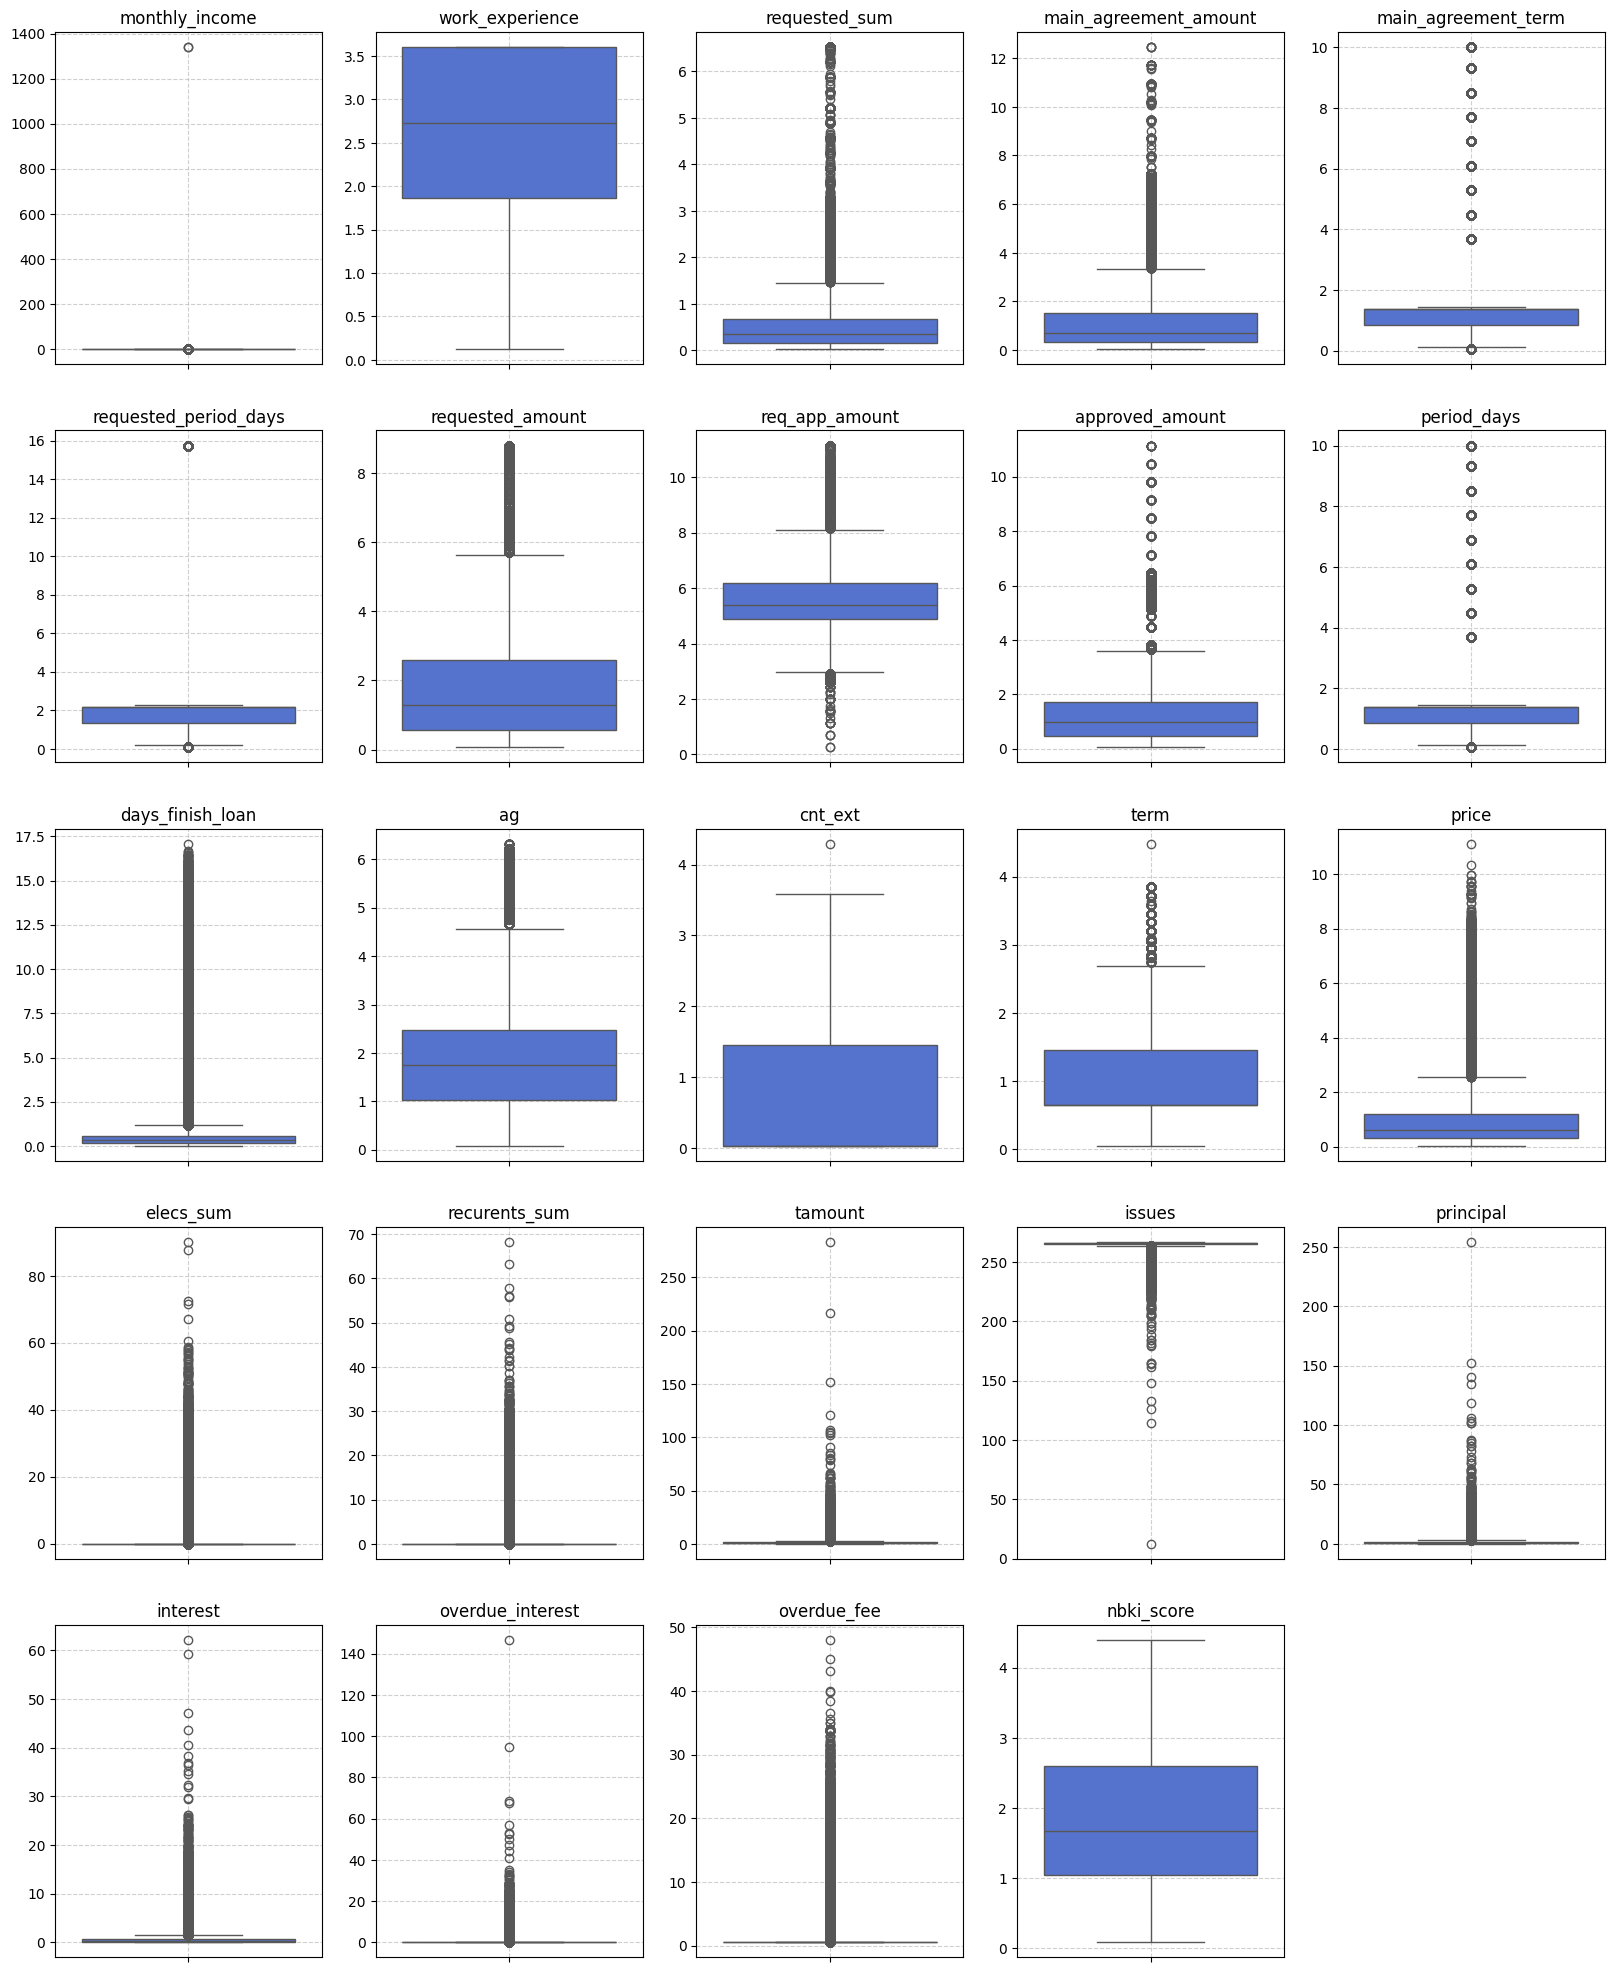

In [10]:
# Анализ выбросов
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))
axes = axes.flatten()
for index, col in tqdm(enumerate(col_cont)):
    sns.boxplot(y=csv_train[col], ax=axes[index], color="royalblue")
    axes[index].set_title(col, fontsize=12)
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")
    axes[index].grid(True, linestyle="--", alpha=0.6)
for i in range(index + 1, len(axes)):
    fig.delaxes(axes[i])
plt.show()

In [10]:
# Доля выбросов
csv_stat = csv_train.copy()
Q1 = csv_stat[col_cont].quantile(0.25)
Q3 = csv_stat[col_cont].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for index in range(len(col_cont)):
    col = col_cont[index]
    h = csv_train[col]
    print(col, round(1 - len(h[(h > lower_bound[col]) & (h < upper_bound[col])]) / len(h.dropna()), 3))

monthly_income 0.061
work_experience 0.0
requested_sum 0.061
main_agreement_amount 0.035
main_agreement_term 0.052
requested_period_days 0.037
requested_amount 0.004
req_app_amount 0.01
approved_amount 0.044
period_days 0.052
days_finish_loan 0.094
ag 0.014
cnt_ext 0.0
term 0.112
price 0.074
elecs_sum 1.0
recurents_sum 1.0
tamount 0.052
issues 0.041
principal 0.041
interest 0.084
overdue_interest 1.0
overdue_fee 1.0
nbki_score 0.0


In [10]:
def custom_corr(x:pd.Series, y:pd.Series):
    if x.name in col_cont and y.name in col_cont:
        return x.corr(y, method='pearson')  # Корреляция Пирсона для количественных переменных
    else:
        return x.corr(y, method='spearman')  # Корреляция Спирмена для остальных случаев

In [11]:
corr_matrix = pd.DataFrame(np.nan, index = col_cont + col_ord, columns = col_cont + col_ord)
for col1 in col_cont + col_ord:
    for col2 in col_cont + col_ord:
        corr_matrix.loc[col1, col2] = custom_corr(csv_train[col1], csv_train[col2])

<Axes: >

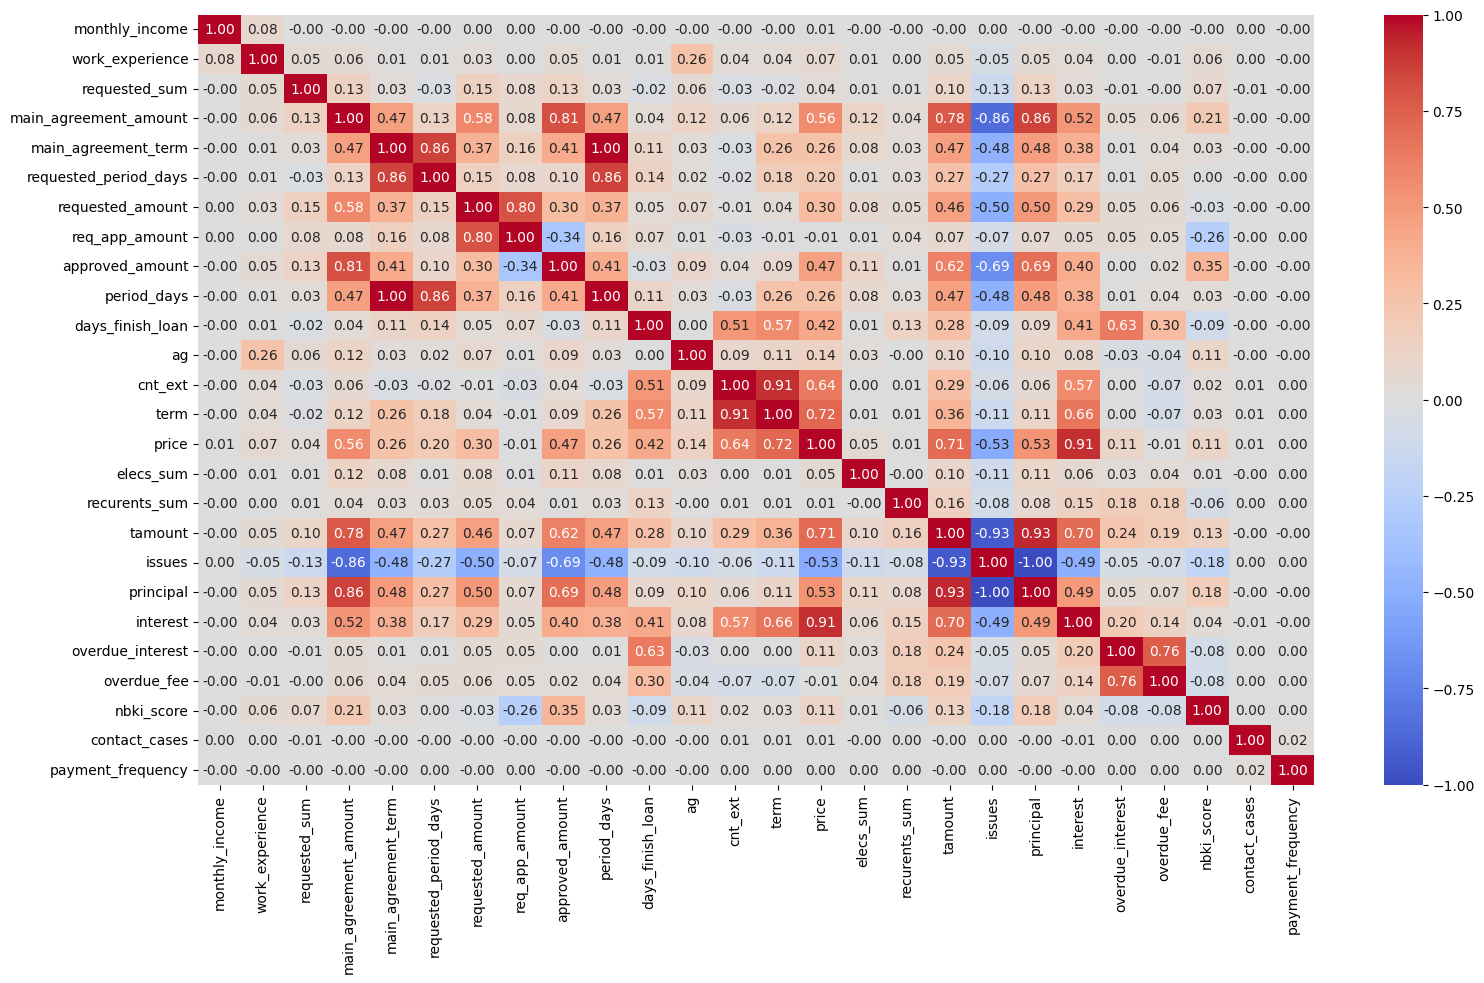

In [12]:
# Корреляция фичей
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f")

In [20]:
# Количество пропусков
nan_ = csv_train[col_cont].isna().sum()[csv_train[col_cont].isna().any()]
nan_

monthly_income               207
work_experience          2648360
requested_sum            3546390
requested_period_days     441618
requested_amount          414836
req_app_amount            414836
cnt_ext                  3582556
term                     3582556
price                    3582816
elecs_sum                   5794
recurents_sum               5794
tamount                     1774
nbki_score                 84476
dtype: int64

In [11]:
# Статистики признаков с пропусками
csv_train[nan_.index].describe().round(3)

,monthly_income,work_experience,requested_sum,requested_period_days,requested_amount,req_app_amount,cnt_ext,term,price,elecs_sum,recurents_sum,tamount,nbki_score
count,4036000.000,1387847.000,489817.000,3594589.000,3621371.000,3621371.000,453651.000,453651.000,453391.000,4030413.000,4030413.000,4034433.000,3951731.000
mean,0.001,2.648,0.621,1.740,1.384,5.503,0.757,1.207,0.955,0.067,0.150,1.031,1.855
std,0.943,1.000,0.997,1.001,1.000,1.000,1.001,1.001,1.001,1.001,1.001,1.003,1.000
min,0.000,0.126,0.030,0.083,0.066,0.262,0.036,0.057,0.046,0.003,0.007,0.049,0.088
25%,0.000,1.864,0.159,1.351,0.551,4.874,0.036,0.646,0.306,0.003,0.007,0.454,1.042
50%,0.000,2.732,0.354,2.166,1.301,5.396,0.036,0.646,0.611,0.003,0.007,0.769,1.675
75%,0.000,3.601,0.679,2.166,2.579,6.180,1.455,1.464,1.215,0.003,0.007,1.324,2.599
max,1339.737,3.601,6.521,15.751,8.797,11.140,4.293,4.481,11.120,90.078,68.196,283.154,4.390


In [12]:
# Распределение таргета на двух выборках каждого признака: выборка содержащая пропуски, выборка без пропусков с значениями меньше 0.05 квантиля
for col in nan_.index:
    if col in ["cnt_ext", "term", "elecs_sum", "recurents_sum"]:
        print(f"---{col}---", '\n', csv_train[csv_train[col].isna()].churn.value_counts(), csv_train[csv_train[col] == csv_train[col].min()].churn.value_counts())
    else:
        print(f"---{col}---", '\n', csv_train[csv_train[col].isna()].churn.value_counts(), csv_train[csv_train[col] <= csv_train[col].quantile(0.05)].churn.value_counts())

---monthly_income--- 
 churn
0    149
1     58
Name: count, dtype: int64 churn
0    147231
1     61250
Name: count, dtype: int64
---work_experience--- 
 churn
0    1870531
1     777829
Name: count, dtype: int64 churn
0    125748
1     52537
Name: count, dtype: int64
---requested_sum--- 
 churn
0    2504019
1    1042371
Name: count, dtype: int64 churn
0    34496
1    14385
Name: count, dtype: int64
---requested_period_days--- 
 churn
0    311989
1    129629
Name: count, dtype: int64 churn
0    236668
1     98112
Name: count, dtype: int64
---requested_amount--- 
 churn
0    293118
1    121718
Name: count, dtype: int64 churn
0    145940
1     60453
Name: count, dtype: int64
---req_app_amount--- 
 churn
0    293118
1    121718
Name: count, dtype: int64 churn
0    138682
1     57898
Name: count, dtype: int64
---cnt_ext--- 
 churn
0    2529598
1    1052958
Name: count, dtype: int64 churn
0    177361
1     73964
Name: count, dtype: int64
---term--- 
 churn
0    2529598
1    1052958
Name: coun

## ПОРЯДКОВЫЕ

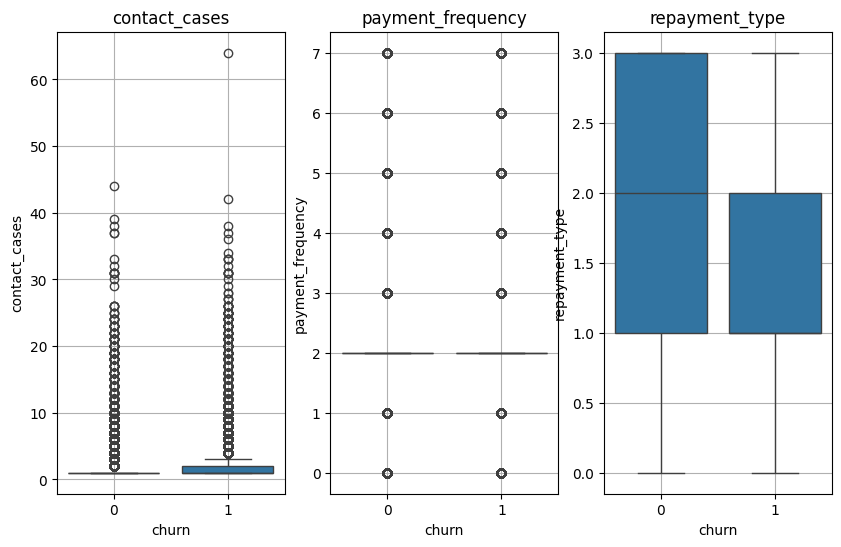

In [10]:
plt.figure(figsize=(10, 6))
for index, col in enumerate(col_ord[:3]):
    plt.subplot(1, 3, index + 1)
    sns.boxplot(data=csv_train, x="churn", y=col)
    plt.title(f"{col}")
    plt.grid()
plt.show()

In [11]:
csv_train[csv_train["churn"] == 0][col_ord[:3]].describe().round(2)

,contact_cases,payment_frequency,repayment_type
count,117377.00,2850077.00,2850077.00
mean,1.43,2.06,1.71
std,1.27,0.90,0.94
min,1.00,0.00,0.00
25%,1.00,2.00,1.00
50%,1.00,2.00,2.00
75%,1.00,2.00,3.00
max,44.00,7.00,3.00


In [12]:
csv_train[csv_train["churn"] == 1][col_ord[:3]].describe().round(2)

,contact_cases,payment_frequency,repayment_type
count,108540.00,1186130.00,1186130.00
mean,1.59,1.98,1.47
std,1.58,0.96,0.96
min,1.00,0.00,0.00
25%,1.00,2.00,1.00
50%,1.00,2.00,1.00
75%,2.00,2.00,2.00
max,64.00,7.00,3.00


In [13]:
csv_train["payment_frequency"] = csv_train["payment_frequency"] + 1
csv_test["payment_frequency"] = csv_test["payment_frequency"] + 1
csv_train["repayment_type"] = csv_train["repayment_type"] + 1
csv_test["repayment_type"] = csv_test["repayment_type"] + 1

In [14]:
csv_train[col_ord].isna().sum()

contact_cases        3810290
payment_frequency          0
repayment_type             0
created_at                 0
start_dt             3581930
dtype: int64

In [15]:
csv_train["start_dt"].fillna(csv_train["created_at"], inplace=True)
csv_train["diff_date"] = csv_train["start_dt"] - csv_train["created_at"]
csv_train["diff_date"] = csv_train["diff_date"].dt.days

csv_test["start_dt"].fillna(csv_test["created_at"], inplace=True)
csv_test["diff_date"] = csv_test["start_dt"] - csv_test["created_at"]
csv_test["diff_date"] = csv_test["diff_date"].dt.days

In [16]:
col_ord.remove("created_at")
col_ord.remove("start_dt")
col_ord.append("diff_date")
for col in ["created_at", "start_dt"]:
    csv_train.drop(columns=col, inplace=True)
    csv_test.drop(columns=col, inplace=True)

## КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ

In [17]:
# Количество уникальных значений каждого признака
for col in col_categor:
    h = csv_train[col].unique().shape[0]
    print(h / csv_train.shape[0], h, col)

0.011749892906880147 47425 settlement
4.6826141473913505e-05 189 region
4.955147245916773e-07 2 gender
2.4775736229583865e-06 10 status
4.955147245916773e-06 20 source
4.707389883620934e-06 19 first_source
7.432720868875159e-07 3 interface
9.910294491833546e-07 4 type
4.955147245916773e-07 2 client_type
4.955147245916773e-07 2 have_extension


In [18]:
# Удаление признаков содержащих большое количество уникальных значений
col_del.append("settlement")
col_del.append("region")
for col in col_del:
    if col in col_categor:
        col_categor.remove(col)

In [19]:
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table).statistic
    n = np.sum(contingency_table.values)
    k = min(contingency_table.shape)
    return np.sqrt(chi2 / (n * (k - 1)))

In [20]:
# Стат тест для выявление зависимости между признаками и таргетом (коэффициент крамера, т.к. выборка большая) 
for col in col_categor:
    contingency_table = pd.crosstab(csv_train[col].dropna(), csv_train["churn"])
    v = cramers_v(contingency_table)
    print(f"V: {v}, {col}")

V: 0.025802545798552238, gender
V: 0.019504468819549283, status
V: 0.1325212290038968, source
V: 0.08863032269533283, first_source
V: 0.0701801389410689, interface
V: 0.09168988553691979, type
V: 0.13355018025894033, client_type
V: 0.11033664611997429, have_extension


In [21]:
# Пропуски
csv_train[col_categor].isna().sum()

gender            0
status            0
source            0
first_source      0
interface         0
type              0
client_type       0
have_extension    0
dtype: int64

# PREPARE

In [22]:
csv_stat = csv_train.copy()
Q1 = csv_stat[col_cont].quantile(0.25)
Q3 = csv_stat[col_cont].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [23]:
def replace_trash(data, lower_bound, upper_bound):
    data = data
    for col in lower_bound.index:
        data.loc[data[col] >= upper_bound[col], col] = upper_bound[col]
        data.loc[data[col] <= lower_bound[col], col] = lower_bound[col]
    return data

In [24]:
csv_train = replace_trash(csv_train, lower_bound, upper_bound)
csv_test = replace_trash(csv_test, lower_bound, upper_bound)

In [25]:
value_for_fill_nan = {"monthly_income" : csv_train[["monthly_income", "status"]].groupby("status").median()["monthly_income"].to_dict(),
                      "work_experience" : csv_train[["work_experience", "status"]].groupby("status").median()["work_experience"].to_dict(),
                      "requested_period_days" : csv_train[["requested_period_days", "type"]].groupby("type").median()["requested_period_days"].to_dict(),
                      "tamount" : csv_train[["tamount", "status"]].groupby("status").median()["tamount"].to_dict(),
                      "nbki_score" : csv_train[["nbki_score", "status"]].groupby("status").median()["nbki_score"].to_dict()} 

In [26]:
def fill_nan(data, value_for_fill_nan):
# # ***Способ заполнения пропусков зависит от смысла признака
    data = data
    data.loc[data["monthly_income"] > 1000, "monthly_income"] = upper_bound["monthly_income"]
    data["monthly_income"].fillna(data["status"].map(value_for_fill_nan["monthly_income"]), inplace=True)
    data["work_experience"].fillna(data["status"].map(value_for_fill_nan["work_experience"]), inplace=True)
    data["requested_period_days"].fillna(data["type"].map(value_for_fill_nan["requested_period_days"]), inplace=True)
    data["fill_requested_sum"] = data["requested_sum"].isna().astype(int) # Колонка отвечающая за пропуски в requested_sum
    data["fill_requested_amount"] = data["requested_amount"].isna().astype(int) # Колонка отвечающая за пропуски в requested_amount
    data["fill_requested_amount_sum"] = data["fill_requested_sum"] * data["fill_requested_amount"] # Колонка отвечающая за пропуски в requested_amount И requested_sum
    data["requested_sum"].fillna(data["requested_amount"], inplace=True); data["requested_sum"].fillna(data["approved_amount"], inplace=True)
    data["requested_amount"].fillna(data["requested_sum"], inplace=True); data["requested_amount"].fillna(data["approved_amount"], inplace=True)
    data["fill_req_app_amount"] = data["req_app_amount"].isna().astype(int) # Колонка отвечающая за пропуски в req_app_amount
    data["req_app_amount"].fillna(data["approved_amount"] - data["requested_amount"], inplace=True)
    data["fill_tamount"] = data["tamount"].isna().astype(int) # Колонка отвечающая за пропуски в tamount
    data["tamount"].fillna(data["type"].map(value_for_fill_nan["tamount"]), inplace=True)
    data["fill_nbki_score"] = data["nbki_score"].isna().astype(int) # Колонка отвечающая за пропуски в nbki_score
    data["nbki_score"].fillna(data["status"].map(value_for_fill_nan["nbki_score"]), inplace=True)
    data["cnt_ext"].fillna(0, inplace=True)
    data["term"].fillna(0, inplace=True)
    data["price"].fillna(0, inplace=True)
    data["elecs_sum"].fillna(0, inplace=True)
    data["recurents_sum"].fillna(0, inplace=True)
    data["contact_cases"].fillna(0, inplace=True)
    return data

In [27]:
csv_train = fill_nan(csv_train, value_for_fill_nan)
csv_test = fill_nan(csv_test, value_for_fill_nan)

In [28]:
col_categor.append("fill_requested_sum")
col_categor.append("fill_requested_amount")
col_categor.append("fill_requested_amount_sum")
col_categor.append("fill_req_app_amount")
col_categor.append("fill_tamount")
col_categor.append("fill_nbki_score")

In [29]:
def create_feature(data):
    # Дополнительные фичи
    data = data
    data["feature_1"] = data["requested_amount"] / data["monthly_income"] # Запрошенная сумма / доход
    data["feature_2"] = data["requested_amount"] / data["requested_period_days"] # Запрошенная сумма / количество запрошенных дней
    data["feature_3"] = (data["elecs_sum"] + data["recurents_sum"]) / data["monthly_income"] # Штрафы / доход
    data["feature_4"] = data["tamount"] / data["monthly_income"] # Кэшфлоу / доход
    data["feature_5"] = data["principal"] / data["monthly_income"] # Сумма долга / доход
    data["feature_6"] = data["contact_cases"] / data["days_finish_loan"] # Количество контактов с кол центром / количество дней для закрытия долга
    data["feature_7"] = data["price"] / data["term"] # Цена пролонгации / срок пролонгации
    data["feature_7"] = data["feature_7"].fillna(0)
    data["feature_8"] = data["issues"] / data["requested_amount"] # Сумма просрочек / запрашиваемая сумма
    data["feature_9"] = data["term"] / data["main_agreement_term"] # Срок пролонгации / одобренный срок
    data["feature_9"] = data["feature_9"].fillna(0)
    data["feature_10"] = data["monthly_income"] / data["payment_frequency"] # Доход / частота получения зарплаты
    # Статистика по каждому id
    data["sum_penalty"] = data["elecs_sum"] + data["recurents_sum"]
    t = data.groupby("client_id").agg({
        "overdue_fee" : "count",
        "monthly_income" : ["mean", "std"],
        "sum_penalty" : ["mean", "std"],
        "diff_date" : "mean",
        "have_extension" : "mean",
        "contact_cases" : "mean",
        "req_app_amount" : ["mean", "std"]
    }).fillna(0).reset_index()
    t.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in t.columns]
    data = data.merge(t, on="client_id", how="left")
    return data, t.columns

In [30]:
csv_train, add_col = create_feature(csv_train)
csv_test, _ = create_feature(csv_test)
col_add_feature = []
for index in range(1, 11):
    col_add_feature.append(f"feature_{index}")
col_add_feature = col_add_feature + add_col.tolist()

In [31]:
encoder = LabelEncoder().fit(csv_train["gender"])
csv_test["gender"] = encoder.transform(csv_test["gender"])
csv_train["gender"] = encoder.transform(csv_train["gender"])

# TRAIN

In [32]:
# Распределние таргета
target = csv_train.churn.value_counts()
target

churn
0    2850077
1    1186130
Name: count, dtype: int64

In [33]:
class_weight = (1 / (target / np.sum(target)) / np.sum(1 / (target / np.sum(target)))).to_dict()
class_weight

{0: 0.2938724401399631, 1: 0.706127559860037}

In [34]:
# Разделение на тренировочную и тестовую выборки
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(csv_train[col_cont + col_add_feature + col_categor + col_ord], csv_train.churn, test_size=0.1, random_state=12312, shuffle=True)

In [35]:
train_pool = Pool(x_train_cat, label=y_train_cat, cat_features=col_categor)
test_pool = Pool(x_test_cat, label=y_test_cat, cat_features=col_categor)

In [36]:
model = CatBoostClassifier(
    iterations = 250,       
    learning_rate = 0.1,
    class_weights = class_weight,
    eval_metric = 'F1',
    custom_metric = ['F1', 'Accuracy'],
    random_seed = 12312,
    verbose = False,
    task_type = 'GPU',
    use_best_model = True
)

In [37]:
model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [38]:
pred = model.predict(x_test_cat)
pred_prob = model.predict_proba(x_test_cat)[:, 1]
print(f"ROC & AUC: {roc_auc_score(y_test_cat, pred_prob)}")
print(f"Accuracy: {accuracy_score(y_test_cat, pred)}")
print(f"F1 score: {f1_score(y_test_cat, pred)}")
print(classification_report(y_test_cat, pred))

ROC & AUC: 0.8563087795764002
Accuracy: 0.8063505119902087
F1 score: 0.677091380813293
              precision    recall  f1-score   support

           0       0.87      0.86      0.86    284657
           1       0.67      0.69      0.68    118964

    accuracy                           0.81    403621
   macro avg       0.77      0.77      0.77    403621
weighted avg       0.81      0.81      0.81    403621



In [39]:
table_feature_importances = pd.DataFrame({"feature":x_train_cat.columns, "importances":model.feature_importances_.round(2)})
table_feature_importances.sort_values("importances", ascending=False)

,feature,importances
35,overdue_fee_count,70.78
51,client_type,24.63
61,repayment_type,1.14
34,client_id,0.93
62,diff_date,0.58
...,...,...
25,feature_2,0.00
26,feature_3,0.00
27,feature_4,0.00
28,feature_5,0.00


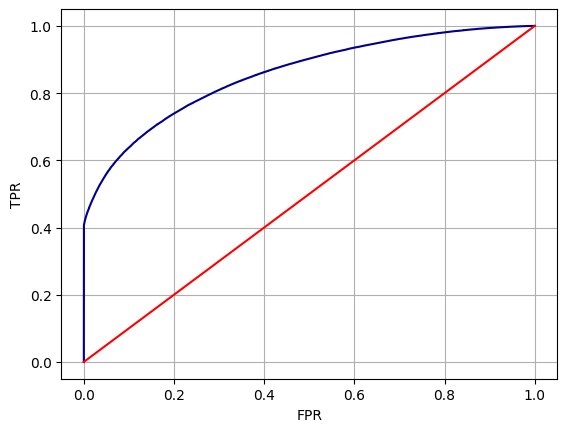

In [40]:
fpr, tpr, _ = roc_curve(y_test_cat, pred_prob)
plt.plot(fpr, tpr, color="darkblue")
plt.plot([0, 1], [0, 1], color="red")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()

In [ ]:
params = {
    "iterations" : 250,   
    "learning_rate" : 0.1,
    "class_weights" : list(class_weight.values()), # Если передавать словарем cv начинает ругаться 
    "eval_metric" : "F1",               
    "loss_function": "Logloss",
    "custom_metric": "F1",
    "task_type" : 'GPU',
    "verbose" : False
}

In [66]:
cv_model = cv(
    pool=Pool(csv_train[col_cont + col_add_feature + col_categor + col_ord], csv_train.churn, cat_features=col_categor),
    params=params,   
    fold_count=5,        
    shuffle=True,   
    partition_random_seed=12312, 
    plot=True,          
    return_models=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
bestTest = 0.7509177006
bestIteration = 247
Training on fold [1/5]
bestTest = 0.7503391587
bestIteration = 248
Training on fold [2/5]
bestTest = 0.7507610892
bestIteration = 246
Training on fold [3/5]
bestTest = 0.7501698723
bestIteration = 240
Training on fold [4/5]
bestTest = 0.7501522678
bestIteration = 248
